In [1]:
import json
import pandas as pd

repo_profiles = {}
repo_teams = {}
with open('repo_profiles_new.json') as rj:
    for rl in rj.readlines():
        line = rl.split('\t')
        repo = line[0]
        profile = json.loads(line[1])
        repo_profiles[repo] = profile
        repo_teams[repo] = repo_profiles[repo].pop('teams')
    
team_profiles = []
teams = []
with open('team_profiles.json') as tj:
    for tl in tj.readlines():
        line = tl.split('\t')
        team = line[0]
        profile = json.loads(line[1])
        team_profiles.append(profile)
        teams.append(team)

In [2]:
repo_profiles_df = pd.DataFrame(repo_profiles).transpose()
repo_profiles_df.fillna('',inplace=True)
team_profiles_df = pd.DataFrame(team_profiles,index=teams)
team_profiles_df.rename(columns={
                                   'repo_size':'size',
                                   'repo_forks':'forks',
                                   'repo_subscribers':'subscribers',
                                   'repo_watchers':'watchers',
                                   'languages':'languages',
                                   'topics':'topics'
                               },inplace=True)

numerics = ['size','forks','subscribers','watchers']

In [3]:
repo_profiles_df[numerics].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C61B0D6D30>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C61B69A160>,
      dtype=object)

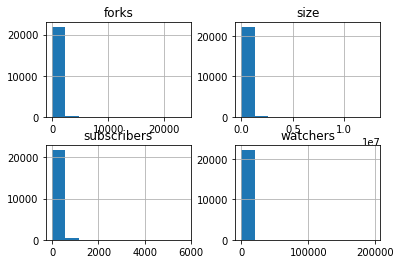

In [4]:
team_profiles_df[numerics].hist()

In [5]:
min = repo_profiles_df[numerics].min()
max = repo_profiles_df[numerics].max()
repo_profiles_df[numerics] = (repo_profiles_df[numerics]-min)/(max-min)
team_profiles_df[numerics] = (team_profiles_df[numerics]-min)/(max-min)

print(repo_profiles_df.iloc[0])
print(team_profiles_df.iloc[0])

forks                    0
languages      [HTML, CSS]
size            4.0849e-05
subscribers    0.000116741
topics                    
watchers                 0
Name: Starbound-Dev/starbound-dev, dtype: object
languages      [HTML, Python, CSS, JavaScript, Shell]
forks                                     0.000245237
size                                      0.000391448
subscribers                                 0.0037357
watchers                                  0.000256156
target                    Starbound-Dev/starbound-dev
topics                                             []
Name: ["AMorporkian", "kharidiron"], dtype: object


In [6]:
repo_profiles_df.describe()

,forks,size,subscribers,watchers
count,14447.000000,14447.000000,14447.000000,14447.000000
mean,0.001187,0.008558,0.007715,0.002713
std,0.010268,0.032399,0.026758,0.014474
min,0.000000,0.000000,0.000000,0.000000
25%,0.000026,0.000143,0.000934,0.000013
50%,0.000136,0.000893,0.002452,0.000111
75%,0.000543,0.004988,0.005837,0.000883
max,1.000000,1.000000,1.000000,1.000000


In [7]:
team_profiles_df.describe()

,forks,size,subscribers,watchers
count,22330.000000,22330.000000,22330.000000,22330.000000
mean,0.002056,0.012387,0.011767,0.004819
std,0.005308,0.034114,0.024004,0.015330
min,0.000000,0.000000,0.000000,0.000000
25%,0.000188,0.001228,0.002495,0.000153
50%,0.000698,0.004055,0.005565,0.001029
75%,0.002045,0.011029,0.012145,0.004452
max,0.123320,1.674898,0.668457,0.666754


In [26]:
import numpy as np

def euclidean_distance(p1,p2):
    distance = np.linalg.norm(p1[numerics]-p2[numerics])**2
    langs = set(p1['languages']).union(p2['languages'])
    topics = set(p1['topics']).union(p2['topics'])
    p1_langs = pd.Series([lang in p1['languages'] for lang in langs])/np.sqrt(len(langs))
    p2_langs = pd.Series([lang in p2['languages'] for lang in langs])/np.sqrt(len(langs))
    p1_topics = pd.Series([topic in p1['topics'] for topic in topics])/np.sqrt(len(topics))
    p2_topics = pd.Series([topic in p2['topics'] for topic in topics])/np.sqrt(len(topics))
    distance += np.linalg.norm(p1_langs-p2_langs)**2 + np.linalg.norm(p1_topics-p2_topics)**2
    distance = np.sqrt(distance)
    return distance



p1 = repo_profiles_df.iloc[0]
p2 = team_profiles_df.iloc[0]
print(euclidean_distance(p1,p2))

0.0036531546696178785


In [ ]:
from queue import PriorityQueue

team_recommendations = []
cnt = 0
for repo,repo_profile in repo_profiles_df.iterrows():
    cnt += 1
    if cnt > 1:
        break
    print(cnt)
    rec = []
    queue = PriorityQueue()
    for team,team_profile in team_profiles_df.iterrows():
        if team in repo_teams[repo]:
            continue
        dis = euclidean_distance(repo_profile,team_profile)
        queue.put_nowait((-dis,team))
        if queue.qsize() > 20:
            queue.get_nowait()
    while queue.qsize()>0:
        rec.append(queue.get_nowait())
    team_recommendations.append(rec)


In [ ]:
for i,rec in enumerate(team_recommendations):
    print(repo_profiles_df.iloc[i].name,end='\t')
    for tm in rec:
        print(json.dumps(list(tm)),end='\t')
    print('\n')

In [54]:
euclidean_numerics_v = np.vectorize(
    lambda p1,p2: np.linalg.norm(p1-p2)**2,signature="(n),(n)->()"
)

def euclidean_non_numerics(p1,p2):
    langs = set(p1[0]).union(p2[0])
    topics = set(p1[1]).union(p2[1])
    p1_langs = pd.Series([lang in p1[0] for lang in langs])/np.sqrt(len(langs))
    p2_langs = pd.Series([lang in p2[0] for lang in langs])/np.sqrt(len(langs))
    p1_topics = pd.Series([topic in p1[1] for topic in topics])/np.sqrt(len(topics))
    p2_topics = pd.Series([topic in p2[1] for topic in topics])/np.sqrt(len(topics))
    return np.linalg.norm(p1_langs-p2_langs)**2 + np.linalg.norm(p1_topics-p2_topics)**2

euclidean_non_numerics_v =  np.vectorize(euclidean_non_numerics,signature="(n),(n)->()")


euclidean_v = np.vectorize(lambda num,non_num:np.sqrt(num+non_num))

non_numerics = ['languages','topics']
dis1 = euclidean_numerics_v(repo_profiles_df.iloc[0][numerics],team_profiles_df.iloc[:10][numerics])
dis2 = euclidean_non_numerics_v(repo_profiles_df.iloc[0][non_numerics],team_profiles_df.iloc[:10][non_numerics])
print(euclidean_v(dis1,dis2))

[0.77460528 0.7746002  1.39690072 1.38790632 1.00000445 1.4142159
 0.70715035 1.34165317 1.00001335 0.57751631]


In [59]:
cnt = 0
for repo,repo_profile in repo_profiles_df.iterrows():
    cnt += 1
    print(cnt)
    if cnt > 1:
        break

    teams = [t for t,p in team_profiles_df.iterrows() if not t in repo_teams[repo]]
    print(teams[0])
    dis_num = euclidean_numerics_v(repo_profile[numerics],team_profiles_df.loc[teams,numerics])
    dis_non_num = euclidean_non_numerics_v(repo_profile[non_numerics],team_profiles_df.loc[teams,non_numerics])
    dis = euclidean_v(dis_num,dis_non_num)
    idxs = sorted(list(range(len(teams))),key=lambda i:dis[i])
    for i in range(50):
        print(teams[idxs[i]])

1
["AMorporkian", "kharidiron"]
["joseph-ortiz", "tacksoo"]
["SimonGoring", "andydawson", "IceAgeEcologist"]
["pkoro", "skanct", "themiszamani", "dpavlos", "kkoumantaros"]
["IgorDePaula", "flavianohonorato"]
["Thooms", "flavray", "florent1933", "AntoineGirard", "Walz", "Wonskcalb", "Alterrien", "jordankevi"]
["dethe", "eddieantonio", "JarrettSpiker", "CelticMinstrel", "amaclean199", "kotarCreative"]
["bsyu1125", "oeon"]
["weaverbel", "ndalyrose", "evanwill", "alexandermendes", "kekoziar", "elizabethwilliams8"]
["HazCod", "danielfarrell", "shatran", "thephw"]
["only-a-ptr", "AnotherFoxGuy", "mikadou"]
["avernet", "ebruchez", "ajw625"]
["mxplusb", "seviet", "kartiklunkad26", "doddatpivotal"]
["sux13", "elmerehbi"]
["Jan0707", "jferiante"]
["ivanbarlog", "RamonSmit"]
["jungor", "williamking", "WarpPrism", "lucifan"]
["54017", "dengal3"]
["jayjiahua", "BillBillBillBill", "dayinji"]
["Ckins", "1900zyh", "laiy"]
["linytsysu", "MchCyLh", "SimbaScorpio", "ValenW"]
["cbroeren", "michaelw8"]
["d